In [9]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.ar_model import AR,ARResults

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA

In [10]:
df = pd.read_csv("csv/dolar_peso_2022.csv", index_col=0,parse_dates=True,skiprows = 18, encoding='latin-1')
data = df.copy()

In [11]:
data.head()

,SF63528
Fecha,
2018-02-01,19.4899
2018-03-01,19.3717
2018-04-01,19.2427
2018-05-01,19.2737
2018-08-01,19.2323


In [12]:
def preprocesing_data(df):
    df.rename(columns={'SF63528' : 'price'} , inplace= True)
    df = df.sort_index()
    df = df.asfreq('b')
    df.interpolate(inplace=True)
                 
                 
    return df

In [13]:
data = preprocesing_data(data)
data.head()

,price
Fecha,
2018-01-02,18.400400
2018-01-03,18.861000
2018-01-04,18.770633
2018-01-05,18.680267
2018-01-08,18.589900


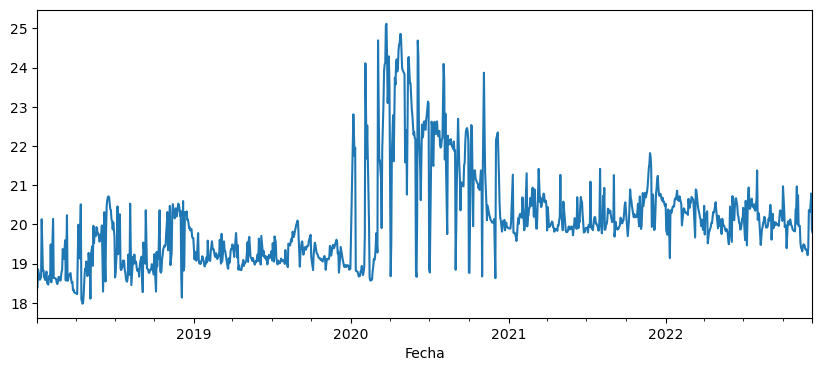

In [14]:
fig, axis = plt.subplots(1,1, figsize = (10,4))
data['price'].plot(ax = axis)
plt.show()

**Decompose the time serie into its trend, seasonality and residues**



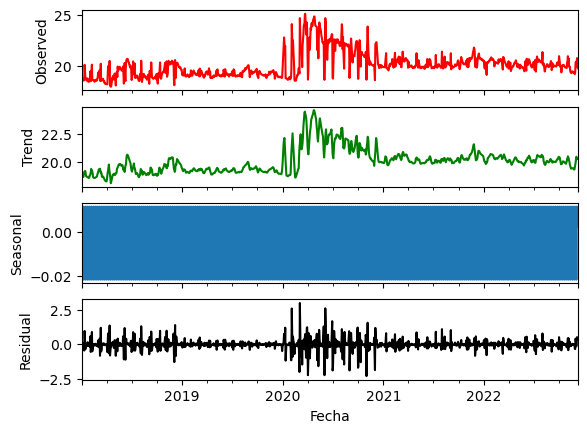

In [15]:
dec_ts_add = seasonal_decompose(data.price, model="additive")

fig, axes = plt.subplots(4, 1, sharex = True)
dec_ts_add .observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
dec_ts_add.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
dec_ts_add .seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
dec_ts_add.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.show()

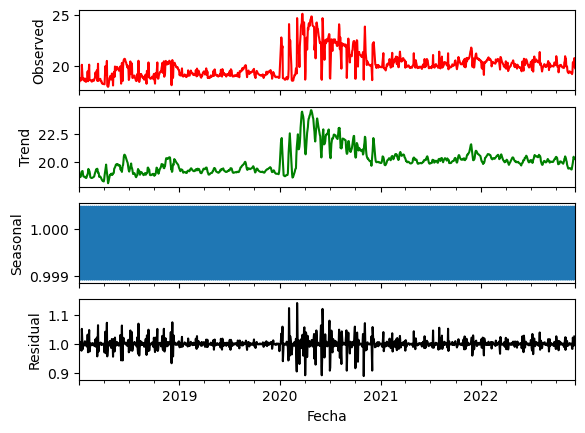

In [16]:
dec_ts_mul = seasonal_decompose(data.price, model="multiplicative")

fig, axes = plt.subplots(4, 1, sharex = True)
dec_ts_mul .observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
dec_ts_add.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
dec_ts_mul .seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
dec_ts_mul.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.show()

In [17]:
adfuller(data['price'])[1]

0.17535387710520295

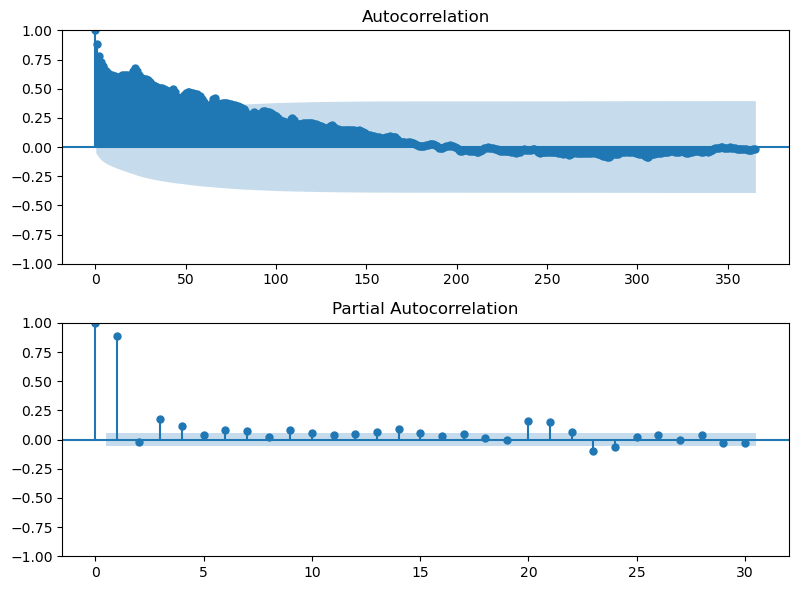

In [18]:
fig, axis = plt.subplots(2,1, figsize = (8,6))
plot_acf(data.price, lags=365, alpha = 0.05, ax = axis[0])
plot_pacf(data.price, lags=30, alpha = 0.05, ax = axis[1])
plt.tight_layout()

In [19]:
data['DESadd12'] = ExponentialSmoothing(data['price'], trend = 'mul',seasonal = 'mul').fit().fittedvalues

model_mul = ExponentialSmoothing(data['price'], trend = 'mul',seasonal = 'mul', seasonal_periods=7).fit()
forescast_mul = model_mul.forecast(36)

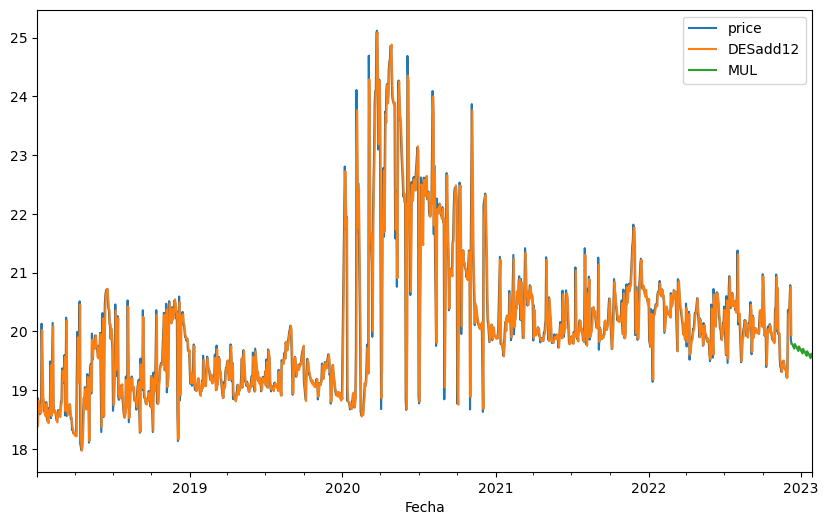

In [20]:
data.plot(figsize=(10,6))
forescast_mul.plot(label = 'MULTIPLICATIVE')
plt.legend()
plt.show()

In [21]:
datos = data['price'].copy().to_frame()


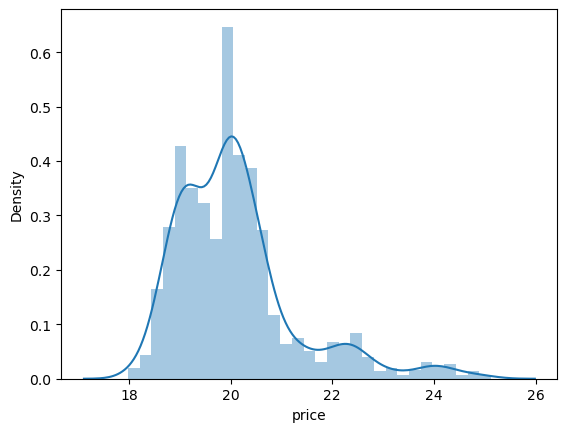

In [22]:
sns.distplot(datos['price'])
plt.show()

In [41]:
limit = int(0.2*len(datos))
train, test = datos.iloc[:-limit], datos.iloc[-limit:]

In [42]:
def test_stacionariedad(df):
    print("The p-value of the Dickie Fuller test is: ", adfuller(df.iloc[1:])[1].round(5))
    if adfuller(df.iloc[1:])[1].round(5) < 0.05:
        print('The time serie is not stationary')
    else:
        print("The time serie is stationary")
    fig, axis = plt.subplots(2,1, figsize = (8,6))
    plot_acf(df.iloc[1:], lags=30, alpha = 0.05, ax = axis[0], zero = False)
        
    plot_pacf(df.iloc[1:], lags=30, alpha = 0.05, ax = axis[1],zero = False,method=('ols'))
    plt.ylim(bottom=-0.3, top = 0.3)
    plt.tight_layout()

The p-value of the Dickie Fuller test is:  0.34981
The time serie is stationary


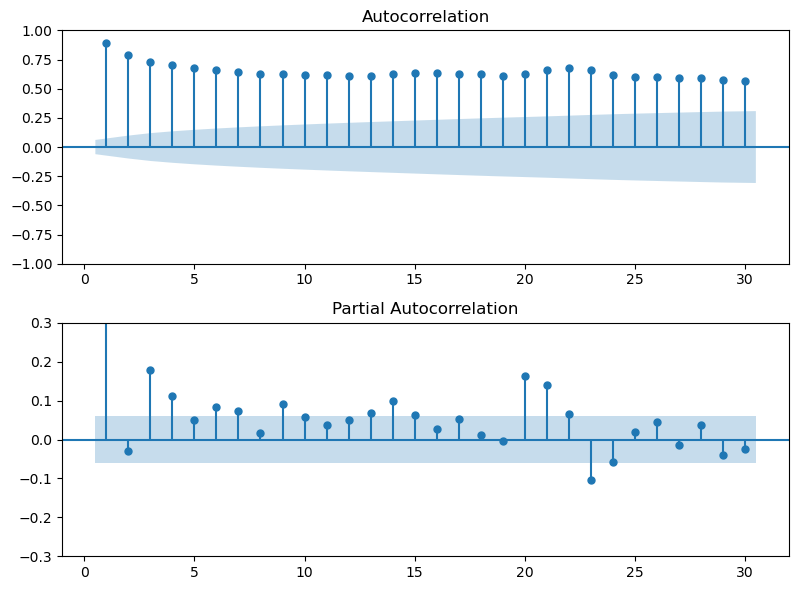

In [43]:
test_stacionariedad(train.price)

In [26]:
datos['diff_1'] = datos['price'].diff(1)

El p-value de la estacionariedad es:  0.0
La serie es estacionaria


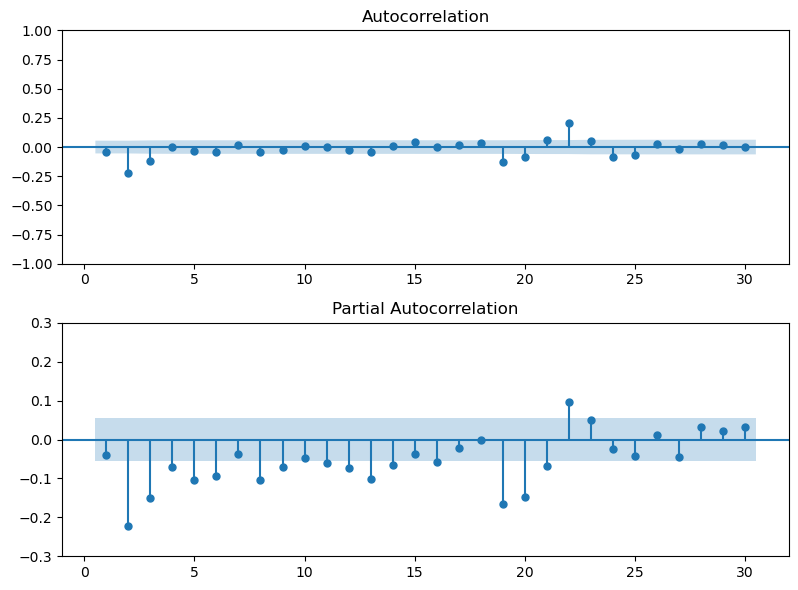

In [27]:
test_stacionariedad(datos['diff_1'].iloc[1:])

In [28]:
from pmdarima import auto_arima

In [44]:
model = auto_arima(train['price'],
                      trace = True,
                      suppress_warning = True,
                      seasonal = False,
                      maxiter=10,
                      max_q=10,
                      max_d=2,
                      max_p=10
                      )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1819.902, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1956.280, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1957.451, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1956.739, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1954.300, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1824.734, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1843.808, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1849.889, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1821.754, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1862.996, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1832.664, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1840.569, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1821.596, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1816.761, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [45]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1032
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -902.225
Date:                Tue, 24 Jan 2023   AIC                           1812.451
Time:                        12:32:15   BIC                           1832.204
Sample:                             0   HQIC                          1819.947
                               - 1032                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5301      0.037     14.157      0.000       0.457       0.603
ma.L1         -0.6788      0.044    -15.301      0.000      -0.766      -0.592
ma.L2         -0.2290      0.035     -6.463      0.000      -0.298      -0.160
sigma2         0.3364      0.005     68.691      0.000       0.327       0.346
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14985.21
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.50
Prob(H) (two-sided):                  0.01   Kurtosis:                        21.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
train_pred = model.predict_in_sample(start=1, end=-1)
prediction, confint = model.predict(n_periods=limit, return_conf_int=True)

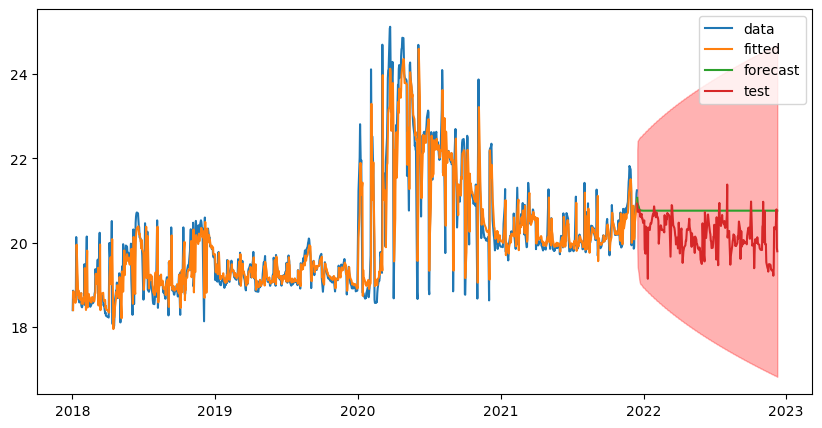

In [47]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(train.index, train['price'], label = 'data')
ax.plot(train.index[1:], train_pred, label = 'fitted')
ax.plot(test.index, prediction, label = 'forecast')
ax.plot(test.index, test['price'], label = 'test')
# test_stacionariedad(train['res'])
ax.fill_between(test.index, confint[:,0],confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

In [33]:
from prophet import Prophet

In [34]:
data.head()

,price,DESadd12
Fecha,,
2018-01-02,18.400400,18.434303
2018-01-03,18.861000,18.387027
2018-01-04,18.770633,18.817532
2018-01-05,18.680267,18.773212
2018-01-08,18.589900,18.657360


In [48]:
data_p = ( data
            .reset_index()[['Fecha', 'price']]
            .rename(columns = {"Fecha": 'ds', 'price': 'y'})

)


In [36]:
data_p

,ds,y
0,2018-01-02,18.400400
1,2018-01-03,18.861000
2,2018-01-04,18.770633
3,2018-01-05,18.680267
4,2018-01-08,18.589900
...,...,...
1284,2022-12-05,20.320000
1285,2022-12-06,20.554100
1286,2022-12-07,20.788200
1287,2022-12-08,19.874000


In [37]:
pd.plotting.register_matplotlib_converters()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(19327.0, 19358.0)

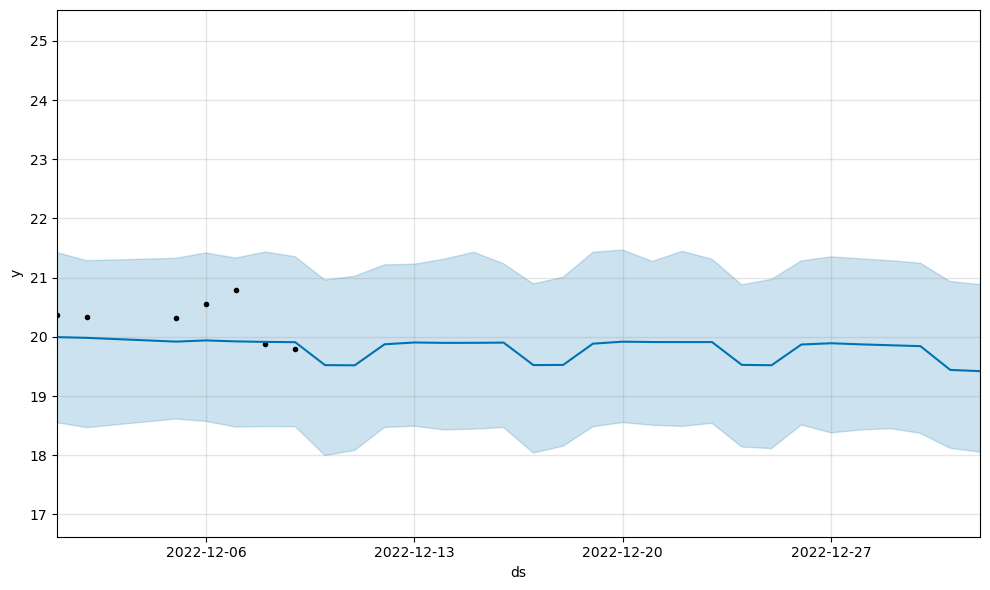

In [51]:
m = Prophet(interval_width=0.95)
m.fit(data_p)
future = m.make_future_dataframe(periods=30, freq = 'D')
forecast = m.predict(future)
m.plot(forecast)
plt.xlim(['2022-12-01','2023-01-1'])
